# **Part of Speech Tagging using Hidden Markov Models**



In this assignment, you are asked to train your **OWN** Hidden Markov Model to predict part of speech tags of words. Steps to the assignment:
1. Download the data from this link - both the web.conllu and wiki.conllu: https://github.com/google-research-datasets/turkish-treebanks/tree/master/data
1. We combined the web and the wiki to have a bigger dataset. Split this dataset (*sentences*) into train/test sets with 0.8/0.2 proportions. Select a random state number and use it consistently to get the same sets while iterating. **This is very important!**
1. Calculate the transition and emission probabilities using the Maximum Likelihood Estimation (MLE). You can use smoothing for transition and emission probabilities.
1. Train two HMMs with two sets of Part-of-Speech tags.

  a. All of the POS tags in the dataset. There are 14 POS tags in the dataset.

  b. Only the tags "ADJ, ADV, NOUN, VERB, PUNC"
1. Add the "\<START>" and "\<END>" tags for calculating the induction and ending probabilities.
1. Predict the tags for the test set using Viterbi algorithm with the trained HMM.
1. Evaluate the prediction with the gold labels. Show confusion matrix for the tags.
1. Compare the two versions of the HMMs in terms of accuracy and F1 score - all tags version, only "ADJ, ADV, NOUN, VERB, PUNC" version.
1. Write a small report on your approaches and results.


## Rules
### Allowed:
 - Use any libraries for anything **other than the HMM training and prediction**.
 - Use strategies to increase the performance like handling unknown or rare words, using a dictionary of open/closed words for prediction, changing smoothing functions, and others.
 - Adding additional coding blocks

### Not allowed:
 - **You need to write your own HMM.** Using the HMM model from an external library is not allowed.

## Assignment Report
Please write a short assignment report at the end of the notebook (max 500 words). Please include all of the following points in the report:
 - Data preparation method
 - How did you calculate of MLE probabilities for transition and emission matrices?
 - Challenges you have faced while writing the HMM model and challenges with the specific dataset
 - Comments about the performance of your HMM tagger
 - Limitations of your approach
 - Possible improvements to the system

## Grading
You will be graded with the following criteria:
 - running complete code (0.5),
 - clear commenting (0.5),
 - data preparation (0.5),
 - HMM transition and emission probability calculation (2)
 - POS tagging the test data with trained HMM using Viterbi algorithm (2)
 - Evaluation of the performance of HMM POS tagger (1)
 - assignment report (1).

Total points for this assignment = 7.5

You can get bonus points (maximum 0.5) by trying extra methods to improve the performance of the HMM model.

## Submission

Submission will be made to SUCourse. Please submit your file using the following naming convention.


`studentid_studentname_hmm_tagger.ipynb  - ex. 26744_aysegulrana_hmm_tagger.ipynb`


**Deadline is December 26th, 23.55pm.**


In [1]:
def read_conll(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Skip metadata lines starting with "#"
            if line.startswith("#"):
                continue

            # Sentence boundary (blank line)
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                # Split the line into columns and extract word and POS tag
                columns = line.split('\t')
                if len(columns) > 3:  # Check to ensure the line has expected columns
                    word = columns[2]
                    if word == '_':
                      continue

                    pos_tag = columns[3]
                    sentence.append((word, pos_tag))

        # Add the last sentence if the file doesn't end with a blank line
        if sentence:
            sentences.append(sentence)

    return sentences

# Usage
web_file_path = "Files/web.conllu"
wiki_file_path = "Files/wiki.conllu"

web_sentences = read_conll(web_file_path)
wiki_sentences = read_conll(wiki_file_path)

sentences = web_sentences + wiki_sentences

In [22]:
print(f"There are {len(sentences)} sentences in total.")

There are 4851 sentences in total.


## 1. Preprocessing function

Investigate the sentences first

In [23]:
for i, sentence in enumerate(sentences):
    while i < 10:
        print(f"{sentence}\n")
        break
    if i == 10:
        break

[('', '<START>'), ('bur', 'PRON'), ('da', 'PRT'), ('öyle', 'VERB'), ('yoksa', 'CONJ'), ('kilo', 'VERB'), ('mı', 'PRT'), ('', '<END>'), ('?', 'PUNCT')]

[('açık', 'NOUN'), ('soru', 'NOUN'), ('müfredat', 'NOUN'), ('uygun', 'ADJ'), ('ol', 'VERB'), ('ol', 'VERB'), ('bil', 'VERB'), ('imkan', 'NOUN'), ('.', 'PUNCT')]

[('', '<START>'), ('bakara', 'NOUN'), ('sure', 'NOUN'), ('248', 'NUM'), ('ayet', 'NOUN'), ('açık', 'NOUN'), ('mı', 'VERB'), ('', '<END>'), ('?', 'PUNCT')]

[('', '<START>'), ('internet', 'NOUN'), ('araştır', 'VERB'), ('açık', 'NOUN'), ('cevap', 'NOUN'), ('bul', 'VERB'), ('', '<END>'), ('.', 'PUNCT')]

[('', '<START>'), ('burun', 'NOUN'), ('kemik', 'NOUN'), ('herhangi', 'DET'), ('bir', 'DET'), ('eğri', 'NOUN'), ('ol', 'VERB'), ('için', 'ADP'), ('kemik', 'NOUN'), ('hiç', 'ADV'), ('dokun', 'VERB'), ('', '<END>'), ('.', 'PUNCT')]

[('', '<START>'), ('(', 'PUNCT'), ('kod', 'NOUN'), ('19', 'NUM'), (')', 'PUNCT'), ("''", 'PUNCT'), ('şekil', 'NOUN'), ('bir', 'DET'), ('mesaj', 'NOUN'), 

In [24]:
def prepare_data(sentences, tag_list):
    
    prepared_sentences = []
        
    # Loop through sentences
    for sentence in sentences:
        
        # Set a temp sentence
        temp_sentence = []
        

        
        # Loop through word/tag tuples in each sentence
        for pair in sentence:
            
            # Set word and tag
            word = pair[0]
            tag = pair[1]
            
            # If tag in our tag list
            if tag in tag_list:
                
                # Keep the sentence
                temp_sentence.append(pair)
                

                
        # If sentence is not entirely cleaned (has tags other than <START> and <END>)
        if len(temp_sentence) != 0:
            
            # Add sentence to the list
            prepared_sentences.append(temp_sentence)



    # Return prepared sentences
    return prepared_sentences


## 2. Train test split

In [25]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

# Set a tag list for restricted version
tag_list = ['ADJ', 'ADV', 'NOUN', 'VERB', 'PUNCT']

# Set data for both restricted and all tags version
five_tags_data = prepare_data(sentences, tag_list)
all_tags_data = sentences

# Do train-test split with 80/20 ratio for both
five_tags_train, five_tags_test = train_test_split(five_tags_data, test_size=0.2, random_state=28)
all_tags_train, all_tags_test = train_test_split(all_tags_data, test_size=0.2, random_state=28)

## 3. Model Training

Train your HMM here.

In [27]:
def create_HMM(train_sentences):
    '''
    type train_sentences: list of tuples
    param train_sentences: The list of tuples  (word, POS tag) for the training data sentences
    rtype: dict
    return: the transitions count dictionary between tags
    rtype: dict
    return: the emissions count dictionary for tags and words
    rtype: dict
    return: the tag count dictionary for the POS tags
    rtype: set
    return: the vocabulary of the corpus
    '''
    
    
    # Initialize dictionaries for transitions and emissions
    transitions = {}
    emissions = {}
    
    # Initialize a dictionary for POS tags
    tags = {}
    
    # Initialize a set for vocabulary
    vocab = set()
    
    # Initialize a word count
    word_count = 0
    
    
    # Loop over sentences
    for sentence in train_sentences:
        
        
        # Insert start tag
        sentence.insert(0, ('', '<START>'))
        
        # Insert end tag
        last_index = len(sentence) - 1
        sentence.insert(last_index, ('', '<END>'))
        
        
        # Loop over pairs
        for index in range(0, len(sentence) - 1):
            
            
            # ----- WORDS and TAGS -----
                        
            # Set the current word and tag
            current_word = sentence[index][0]
            current_tag = sentence[index][1]
            
            # Increase word count
            if current_word != '':
                word_count += 1
            
            # Set the next word and tag
            next_word = sentence[index + 1][0]
            next_tag = sentence[index + 1][1]
            
            
            # ----- TRANSITIONS -----
            
            # Add current tag to transitions
            if current_tag not in transitions:
                transitions[current_tag] = {next_tag: 1}
            else:
                if next_tag not in transitions[current_tag]:
                    transitions[current_tag][next_tag] = 1
                else:
                    transitions[current_tag][next_tag] += 1
                
                
            # ----- EMISSIONS -----
            if current_word != '':
                if current_tag not in emissions:
                    emissions[current_tag] = {current_word: 1}
                else:
                    if current_word not in emissions[current_tag]:
                        emissions[current_tag][current_word] = 1
                    else:
                        emissions[current_tag][current_word] += 1
            
            
            # ----- TAGS -----
                
            # Add tags to tags
            if current_tag not in tags.keys():
                tags[current_tag] = 1
            else:
                tags[current_tag] += 1
                
            
            # ----- WORDS -----
            if current_word != '':
                vocab.add(current_word)
    
    
    return transitions, emissions, tags, vocab, word_count

In [28]:
# Create HMM for both restricted, 5 tags version and all tags version
five_tags_transitions, five_tags_emissions, five_tags_tags, five_tags_vocab, five_tags_word_count = create_HMM(five_tags_train)
all_tags_transitions, all_tags_emissions, all_tags_tags, all_tags_vocab, all_tags_word_count = create_HMM(all_tags_train)

## 4. POS tag prediction for test data

Write Viterbi algorithm to predict the POS tags of the test data.

In [29]:
import numpy as np
import math
def viterbi(test_sentence, transitions, emissions, tag_counts, word_count):
    '''
    type test_sentence: list of strings
    param test_sentence: list of words in a sentence
    type transitions: dict
    param: the transitions count dictionary between tags
    type emissions: dict
    param: the emissions count dictionary for tags and words
    type tag_counts: dict
    param: the tag count dictionary for the POS tags
    type word_count: int
    param: the word count of the training corpus
    rtype: list
    return: the list of predicted tags for the test sentence
    '''
    
    #viterbi matrix for the test sentence. The matrix has +2 in each side since we add
    #START and END tags for probability calculation.
    v_matrix = np.empty(shape=(len(tag_counts)+2,len(test_sentence)+2))
    v_matrix.fill(-1)
    v_matrix[0][0] = 0

    # fill up the viterbi matrix for each cell, starting with the first word.
    # for every word, check each tag's probability of appearing here.
    ## iterate over the tags:
    ## calculate the best transition probability for the current tag from a previous tag (again iteration of all possible tags)
    ## calculate the emission probability of word coming up from the current tag
    ## sum them up to get to the best probability of P(tag|word).
    ## keep the best path coming to that cell
    #after filling up the viterbi matrix, follow the best path back to predict the tags from the final cell.
    # in the end you are looking at len(tags)xlen(tags) possibilities for each word


    ### WRITE YOUR CODE HERE ###


        
    # Initialize dictionaries to keep tags and their indices
    tag_list = list(tag_counts.keys())
    tag_indices = {tag: index for index, tag in enumerate(tag_list)}
    
    # Set start and end tag's indices
    tag_indices['<START>'] = len(tag_list)
    tag_indices['<END>'] = len(tag_list) + 1
    reversed_tag_indexes = {index: tag for tag, index in tag_indices.items()}
    
    # Initialize number of tags, and words in sentence
    num_tags = len(tag_counts)
    num_words = len(test_sentence)
    
    # Initialize a backpointer
    backpointer = [{} for _ in range(num_words + 2)]
    
    
    
    # ----- For the <START> tag and first word
    
    # Loop over tags
    for current_tag in tag_counts.keys():
        
        
        # Ensure that current tag is not start or end (we cannot get start after start or end after start
        if current_tag not in ['<START>', '<END>']:
            
            
            # Transition probability
            total_transition_count = sum(transitions['<START>'].values())
            transition_count_to_tag = transitions['<START>'].get(current_tag, 0)
            transition_probability = math.log((transition_count_to_tag + 1) / (total_transition_count + len(tag_counts) + 1))
    
    
            # Emission probability
            word = test_sentence[0]
            total_emission_count = sum(emissions[current_tag].values())
            emission_count_to_word = emissions[current_tag].get(word, 0)
            emission_probability = math.log((emission_count_to_word + 1) / (total_emission_count + word_count))
            
            
            # Total probability
            total_probability = transition_probability + emission_probability
            
            
            # Update the matrix
            idx = tag_indices[current_tag]
            v_matrix[idx][1] = v_matrix[tag_indices['<START>']][0] + total_probability
            
            
            # Update backpointer
            backpointer[1][idx] = tag_indices['<START>']
    
    
    
    # ----- For all the other tags except <END>
    for i, word in enumerate(test_sentence[1:], 1):
        
        
        # Loop over possible tags for the word
        for current_tag in tag_counts.keys():
            
            
            # Ensure that tag is not start or end (these tags do not have a corresponding word)
            if current_tag not in ['<START>', '<END>']:
                
                
                # Set tag's index
                current_tag_index = tag_indices[current_tag]
                
                # Set probability and best previous tag's index
                max_probability = -np.inf
                best_previous_tag_index = None
                
                
                # Loop over all possible previous tags
                for previous_tag in tag_counts.keys():
                    
                    
                    # Ensure that tag is not start or end
                    if previous_tag not in ['<START>', '<END>']:
                        
                        
                        # Set previous tag's index
                        previous_tag_index = tag_indices[previous_tag]
                        
                        
                        # Transition probability
                        total_transition_count = sum(transitions[previous_tag].values())
                        transition_count_to_tag = transitions[previous_tag].get(current_tag, 0)
                        transition_probability = math.log((transition_count_to_tag + 1) / (total_transition_count + len(tag_counts) + 1))
                
                
                        # Emission probability
                        total_emission_count = sum(emissions[current_tag].values())
                        emission_count_to_word = emissions[current_tag].get(word, 0)
                        emission_probability = math.log((emission_count_to_word + 1) / (total_emission_count + word_count))
                        
                        
                        # Calculate total probability
                        total_probability = v_matrix[previous_tag_index][i] + transition_probability + emission_probability
                        
                        
                        # Update max probability if necessary
                        if total_probability > max_probability:
                            max_probability = total_probability
                            best_previous_tag_index = previous_tag_index
                
                
                # If we have a best prev tag
                if best_previous_tag_index is not None:
                    
                    
                    # Update Viterbi matrix and backpointer
                    v_matrix[current_tag_index][i + 1] = max_probability
                    backpointer[i + 1][current_tag_index] = best_previous_tag_index
    
    
    
    # ----- For the <END> tag
    
    
    # Set max prob and best prev tag
    max_probability = -np.inf
    best_previous_tag_index = None
    
    
    # Loop over tags
    for current_tag in tag_counts.keys():
        
        
        # Ensure that tag is not start or end (cannot have start -> end or end -> end)
        if current_tag not in ['<START>', '<END>']:
            
            
            # Set tag's index
            current_tag_index = tag_indices[current_tag]
            
            
            # Transition probability
            total_transition_count = sum(transitions[current_tag].values())
            transition_count_to_end = transitions[current_tag].get('<END>', 0)
            transition_probability = math.log((transition_count_to_end + 1) / (total_transition_count + len(tag_counts) + 1))
            
            
            # Total probability
            total_probability = v_matrix[current_tag_index][num_words] + transition_probability
            
            
            # Update max probability if necessary
            if total_probability > max_probability:
                max_probability = total_probability
                best_previous_tag_index = current_tag_index
    
    
    
    # ----- Do backtracking
    
    
    # Set a list for predicted tags
    predicted_tags = [None] * num_words
    
    # Set current tag's index
    current_tag_index = best_previous_tag_index
    
    
    # Loop over words in sentence backwards
    for i in range(num_words, 0, -1):
        
        
        # Get the best tag
        tag = reversed_tag_indexes[current_tag_index]
        
        # Add tag to the list
        predicted_tags[i-1] = tag
        
        # Update current tag
        current_tag_index = backpointer[i][current_tag_index]
    
    
    
    return predicted_tags

## 5. Evaluate your HMM

Use the test data labels and compare to your prediction. Use the accuracy and F1 score as the performance metrics. Show the confusion matrix for the prediction vs gold labels.


### All Tags Version

Accuracy: 0.8548230187832073
F1 Score: 0.8379174072661453


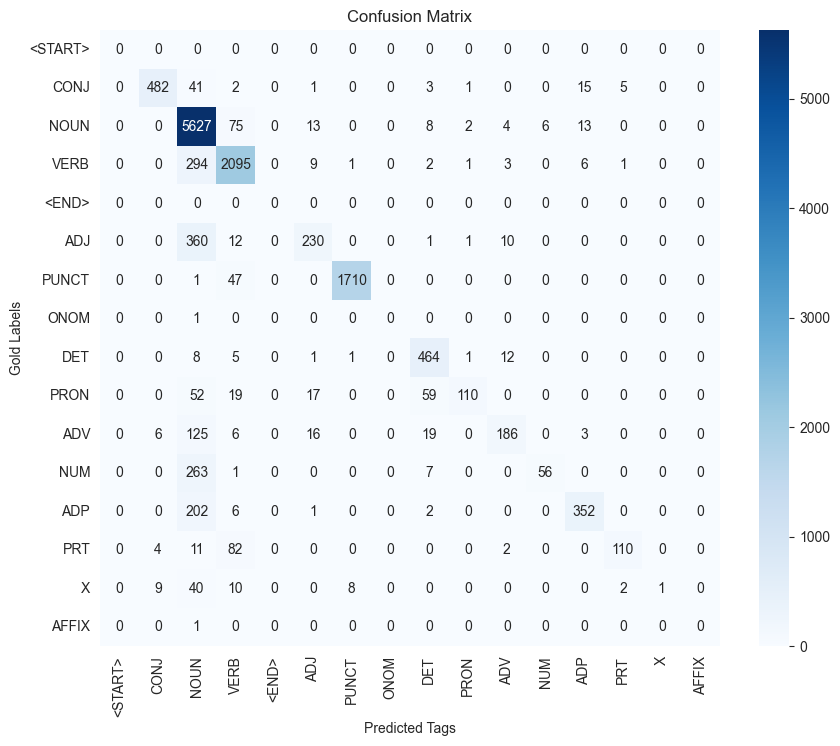

In [30]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### WRITE YOUR CODE HERE ###


# ----- ALL TAGS VERSION

# Initialize lists to store gold tags and predicted tags
gold_labels = []
predicted_tags = []


# Loop over sentences
for sentence in all_tags_test:
    
    
    # Set words and gold labels
    words = [word for word, _ in sentence]
    gold_label = [pos for _, pos in sentence]
    
    
    # Get predictions using the viterbi function
    predicted = viterbi(words, all_tags_transitions, all_tags_emissions, all_tags_tags, all_tags_word_count)
    
    # Add to the lists
    gold_labels.extend(gold_label)
    predicted_tags.extend(predicted)


# Calculate accuracy and f1 scores
accuracy = accuracy_score(gold_labels, predicted_tags)
f1 = f1_score(gold_labels, predicted_tags, average='weighted')

# Do a confusion matrix
cm = confusion_matrix(gold_labels, predicted_tags, labels=list(all_tags_tags.keys()))


# Print results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(all_tags_tags.keys()), yticklabels=list(all_tags_tags.keys()))
plt.xlabel("Predicted Tags")
plt.ylabel("Gold Labels")
plt.title("Confusion Matrix")
plt.show()

### Five Tags Version

Accuracy: 0.9106765812907371
F1 Score: 0.901664408586575

Classification Report:


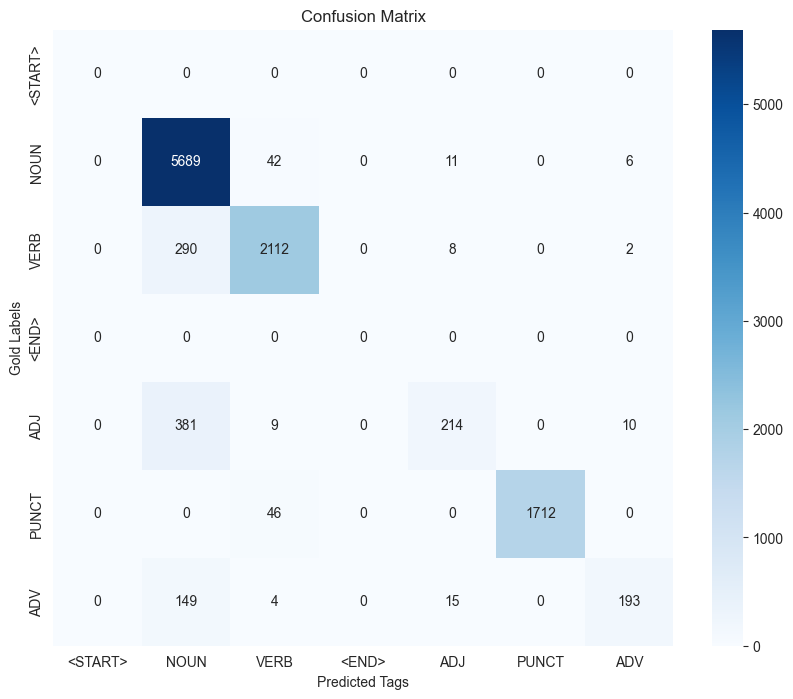

In [31]:
# ----- FIVE TAGS VERSION


# Initialize lists to store gold tags and predicted tags
gold_labels = []
predicted_tags = []


# Loop over sentences
for sentence in five_tags_test:
    
    
    # Set words and gold labels
    words = [word for word, _ in sentence]
    gold_label = [pos for _, pos in sentence]
    
    
    # Get predictions using the viterbi function
    predicted = viterbi(words, five_tags_transitions, five_tags_emissions, five_tags_tags, five_tags_word_count)
    
    
    # Add to the lists
    gold_labels.extend(gold_label)
    predicted_tags.extend(predicted)


# Calculate accuracy and f1 scores
accuracy = accuracy_score(gold_labels, predicted_tags)
f1 = f1_score(gold_labels, predicted_tags, average='weighted')

# Do a confusion matrix
cm = confusion_matrix(gold_labels, predicted_tags, labels=list(five_tags_tags.keys()))


# Print results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("\nClassification Report:")


# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(five_tags_tags.keys()), yticklabels=list(five_tags_tags.keys()))
plt.xlabel("Predicted Tags")
plt.ylabel("Gold Labels")
plt.title("Confusion Matrix")
plt.show()

## 6. Explanation

### 1. Data preparation method
In my preprocessing function, what I did was to remove all tags except the provided ones in the tag list. If sentence was left with only <START> and <END> tags, I did not include it.

### 2. How did you calculate of MLE probabilities for transition and emission matrices?
#####
**For transition probabilities, I thought:**

transitions from previous tag to current tag / transitions from previous tag to all tags

So, I counted these values. However, since both could be zero, I used smoothing.
Then, I took the logarithm of the value to avoid underflow.
#####
**For emission probabilities, I thought:**

emissions from current tag to word / emissions from current tag to all words

Again, I counted the values and used smoothing to avoid underflow. Then took the logarithm.

### 3. Challenges you have faced while writing the HMM model and challenges with the specific dataset
I did not face a lot of challenges when writing the HMM model. Including <START> and <END> tags were a little bit of a problem since they do not have corresponding words, so wanted to included them in the transition probabilities but not emission probabilities, however, writing the code of it was not problematic.

For the dataset, I think the number of tags is just too much. Because of Turkish's structure, words are divided a lot and I think this makes it a lot more complicated. I will continue from this in next part.

### 4. Comments about the performance of your HMM tagger
I think it performs good overall. Both have a f1 score > 0.8 and five tags version have an f1 score of 0.9, which was a pleasant surprise for me as I expected lower scores.

As I said, words are divided a lot and having lots of tags make the prediction harder because it means less data for every transition and emission overall, that's why five tags performed better I guess.

### 5. Limitations of your approach
Unseen words are of course a big problem because the emission probability gets ruined in such case. Also, I am not really proud with my Viterbi implementation, I am not confident if it works correctly and it's probably not really good in terms of computational cost.

### 6. Possible improvements to the system
Maybe some other methods could be searched for handling unseen words, and it's computational complexity could be improved.